In [1]:
import os 
import sys
import pandas as pd
import numpy as np

In [2]:
current_directory = os.getcwd()
sys.path.append(current_directory)

In [3]:
financial_data = pd.read_excel('Quarterly Data (with Employees).xlsx')

In [4]:
financial_data_copy = financial_data
# financial_data = financial_data_copy

In [5]:
quarter_categories = list(financial_data['Fiscal Data Year and Quarter'].unique())
quarter_category_number = np.arange(len(quarter_categories)) + 1
quarter_category_number = quarter_category_number.tolist()

quarter_map = dict(zip(quarter_categories, quarter_category_number))
quarter_map[np.nan] = np.nan

financial_data['time'] = financial_data['Fiscal Data Year and Quarter'].map(quarter_map)

time_col = financial_data.pop('time')
financial_data.insert(2, 'time', time_col)

In [8]:
identifiers = ['Ticker Symbol',
               'time', 
               'Date']

output = ['Revenue - Total']

physical_capital = ['Property, Plant and Equipment - Total (Gross)',
                    'Inventories - Total',
                    'Working Capital (Balance Sheet)']

non_physical_capital = ['Research and Development Expense',
                        'Intangible Assets - Total']

depreciation_cols = ['Depreciation, Depletion and Amortization (Accumulated)',
                     'Depreciation and Amortization']

labor = ['Employees_pred_point']

additional_input_variable = ['Inventory - Raw Materials', 'Cost of Goods Sold']

cols = identifiers + output + physical_capital + non_physical_capital + depreciation_cols + labor + additional_input_variable

financial_data = financial_data[cols]

financial_data['Physical Capital'] = financial_data[physical_capital].sum(axis=1)
financial_data['Non-Physical Capital'] = financial_data[non_physical_capital].sum(axis=1)
financial_data['PC & NPC'] = financial_data['Physical Capital'] + financial_data['Non-Physical Capital']

In [10]:
financial_data = financial_data.rename(columns={'Employees_pred_point': 'Total Employment'})

financial_data = financial_data[financial_data['Total Employment'].notna()]
financial_data = financial_data[financial_data['Depreciation, Depletion and Amortization (Accumulated)'].notna()]
financial_data['Ticker Symbol'].astype(str)

financial_data['Depreciation, Depletion and Amortization (Accumulated)'] = pd.to_numeric(
        financial_data['Depreciation, Depletion and Amortization (Accumulated)'], errors='coerce')


In [11]:
missing_values = pd.DataFrame(financial_data.isna().sum())

missing_values.rename(columns={0: 'Missing Values'}, inplace=True)
missing_values[missing_values != 0].dropna()

,Missing Values
Research and Development Expense,1218.0
Inventory - Raw Materials,1255.0


In [12]:
financial_data.describe()

,time,Date,Revenue - Total,"Property, Plant and Equipment - Total (Gross)",Inventories - Total,Working Capital (Balance Sheet),Research and Development Expense,Intangible Assets - Total,"Depreciation, Depletion and Amortization (Accumulated)",Depreciation and Amortization,Total Employment,Inventory - Raw Materials,Cost of Goods Sold,Physical Capital,Non-Physical Capital,PC & NPC
count,13069.000000,13069,13069.000000,13069.000000,13069.000000,13069.000000,11851.000000,13069.000000,13069.000000,13069.000000,13069.000000,11814.000000,13069.000000,13069.000000,13069.000000,13069.000000
mean,33.650853,2019-01-28 19:52:57.993725696,882.739120,1997.840390,268.554259,835.780370,89.431189,1325.427485,1180.276280,59.888576,0.521316,79.869247,442.095626,3102.175019,1406.523898,4508.698916
min,1.000000,2010-10-31 00:00:00,0.000000,0.000000,0.000000,-23405.000000,-0.082000,0.000000,0.000000,0.000000,0.005099,0.000000,-0.060000,-2006.000000,-0.080000,-186.902000
25%,21.000000,2015-09-30 00:00:00,13.795000,18.147000,0.018000,18.808000,1.937000,3.598000,9.170000,0.609000,0.087382,0.000000,6.579000,51.055000,8.507000,68.031000
50%,36.000000,2019-09-30 00:00:00,94.340000,98.266000,14.159000,138.099000,11.970000,45.568000,44.394000,3.953000,0.374327,3.443500,36.077000,322.319000,65.195000,494.600000
75%,48.000000,2022-09-30 00:00:00,429.000000,599.469000,139.800000,547.351000,45.000000,504.055000,309.747000,22.419000,0.752274,44.306500,185.182000,1365.000000,590.574000,2169.200000
max,61.000000,2025-02-28 00:00:00,124300.000000,245585.106000,12993.000000,62079.000000,8268.000000,138456.000000,145675.302000,5514.681000,2.402006,5576.000000,67005.000000,310004.080000,140690.000000,312407.836000
std,16.217524,NaN,4971.261043,11124.263837,812.203173,3025.856497,375.055523,5338.856005,6698.602693,273.387966,0.508999,312.858472,2718.914174,13779.949322,5462.454584,16129.662256


In [13]:
financial_data = financial_data[(financial_data['Revenue - Total'] > 0)
                                & (financial_data['Cost of Goods Sold'] > 0)
                                & (financial_data['PC & NPC'] > 0)
                                & (financial_data['time'].notna())]

In [14]:
symbols = list(financial_data['Ticker Symbol'].unique())

dfs = {}
for symbol in symbols:
    dfs[symbol] = financial_data[financial_data['Ticker Symbol'] == symbol].copy()

In [15]:
target_col = 'Depreciation, Depletion and Amortization (Accumulated)'

for symbol, df in dfs.items():
    # Find the index of the first non-NaN value in the target column
    first_valid_index = df[target_col].first_valid_index()

    # If a valid index exists, trim the DataFrame starting from that row
    if first_valid_index is not None:
        dfs[symbol] = df.loc[first_valid_index:].reset_index(drop=True)

In [16]:
def reset_diff_on_drop(series):
    series = series.copy()
    # Detect where value drops (i.e., negative difference)
    drops = series.diff() < 0
    # Cumulative sum to create a group ID that resets on each drop
    group = drops.cumsum()
    # Compute the difference within each group
    return series.groupby(group).diff()

In [17]:
def capital_measures(capital_variable, measure_number, lagged_periods):
    for symbol, df in dfs.items():
        try:
            df = df.copy()

            dep_col = 'Depreciation, Depletion and Amortization (Accumulated)'
            da_total_col = 'Depreciation and Amortization'

            df[dep_col] = pd.to_numeric(df[dep_col], errors='coerce')
            df[capital_variable] = pd.to_numeric(df[capital_variable], errors='coerce')
            df[da_total_col] = pd.to_numeric(df[da_total_col], errors='coerce')

            # Depreciation Expense (reset diff on drops)
            df['Depreciation Expense'] = reset_diff_on_drop(df[dep_col])

            # Change in Gross PPE (same logic)
            df['Change in Capital'] = reset_diff_on_drop(df[capital_variable])

            # Depreciation Rate
            df['Depreciation Rate'] = df['Depreciation Expense'] / df[capital_variable]

            # Capital Expenditure
            df['Capital Expenditure'] = df['Change in Capital'] + df[da_total_col]            
            
            #df = df.dropna()

            df = df.reset_index()
            
            for row in df['index']:
                lag = row - lagged_periods
                t_1 = row - 1
                
                # If lag is out of bounds, just use observed capital
                if lag < 0:
                    df.loc[row, f'Capital Measure {measure_number}'] = 0
                
                # If necessary components are missing, also fall back to observed capital
                elif (pd.isna(df.loc[row, 'Depreciation Expense']) or pd.isna(df.loc[row, 'Change in Capital']) or pd.isna(df.loc[lag, 'Capital Expenditure']) or pd.isna(df.loc[t_1, capital_variable])):
                    df.loc[row, f'Capital Measure {measure_number}'] = df.loc[row, capital_variable]
                
                # Otherwise, apply the recursive formula
                else:
                    df.loc[row, f'Capital Measure {measure_number}'] = ((1 - df.loc[row, 'Depreciation Rate']) * df.loc[t_1, capital_variable] + df.loc[lag, 'Capital Expenditure'])
            
            dfs[symbol] = df

        except KeyError:
            print(f"Missing required columns in {symbol}, skipping.")

In [18]:
capital_measures('PC & NPC', 1, 0)
capital_measures('PC & NPC', 2, 3)

In [19]:
financial_data = pd.DataFrame()

for df in dfs.values():
    financial_data = pd.concat([financial_data, df])

financial_data.drop(columns={'index', 'level_0'}, inplace=True)

In [20]:
capital1 = financial_data
capital2 = financial_data[financial_data['Capital Measure 2'] > 0]

In [ ]:
from pandas.api.types import is_numeric_dtype
from scipy.stats import skew

capital1 = capital1.copy()
capital2 = capital2.copy() 

# manual log transformations
cols_to_log = ['Revenue - Total', 'Capital Measure 1']
for col in cols_to_log:
    capital1[col] = np.log1p(capital1[col])

cols_to_log_2 = ['Revenue - Total', 'Capital Measure 1', 'Capital Measure 2']
for col in cols_to_log_2:
    capital2[col] = np.log1p(capital2[col])

log_col = []

def log_transformation(df):
    # define columns to exclude from further processing
    exclude_cols = ['time', 'Revenue - Total', 'Capital Measure 1', 'Capital Measure 2', 'Total Employment']
    
    for col in df.columns:
        if is_numeric_dtype(df[col]) and col not in exclude_cols:
            skewness_value = skew(df[col], nan_policy='omit')            
            if abs(skewness_value) > 1:
                log_col.append(col)
                df[col] = np.log1p(df[col]) 

# apply function
log_transformation(capital1)
log_transformation(capital2)

/Users/alexanderperalta/anaconda3/envs/finance_project/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


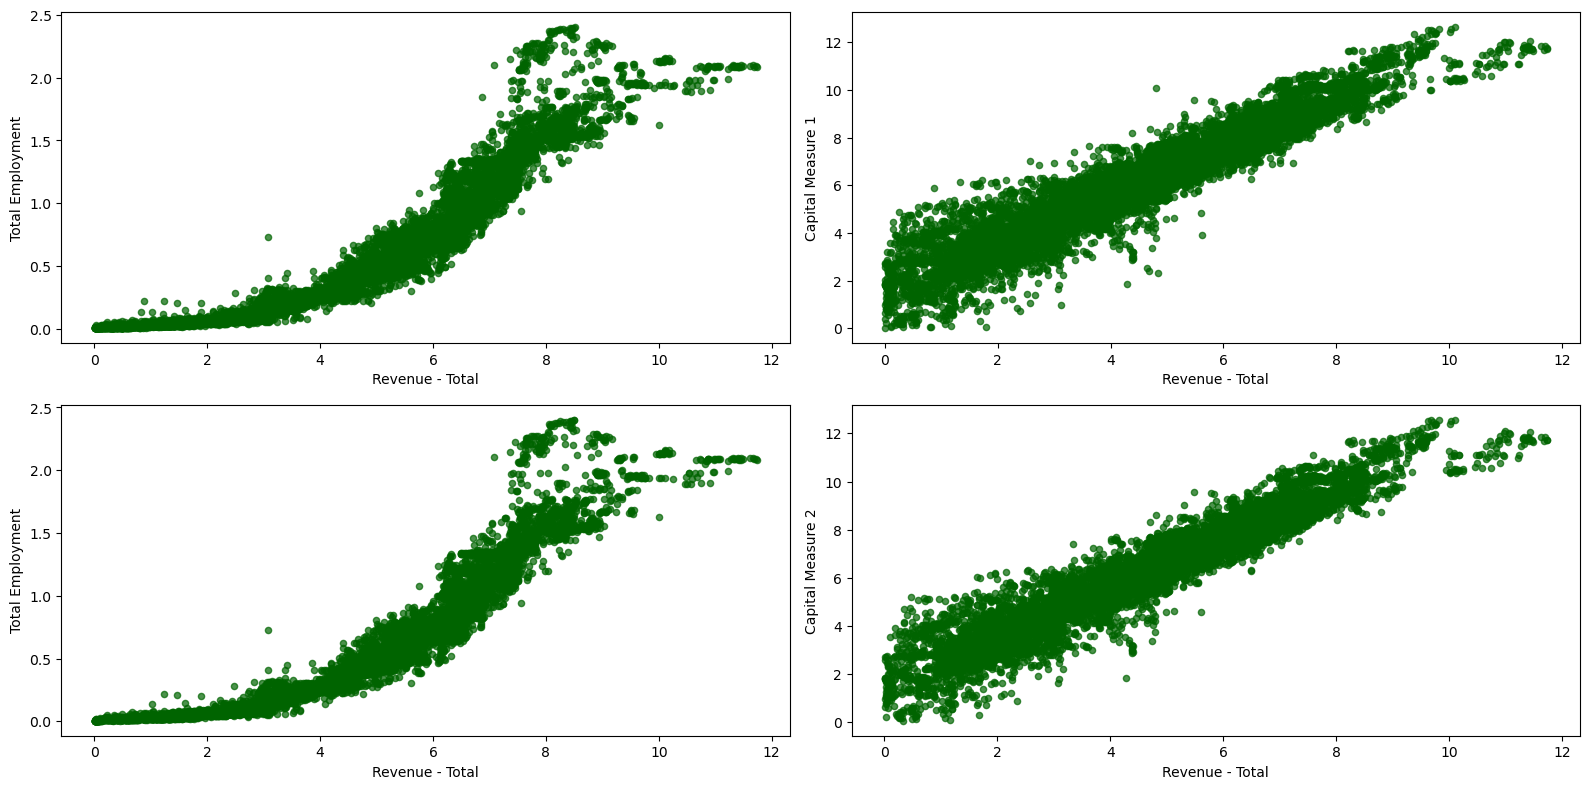

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# What you want on the y‑axis in each subplot
panels = [(capital1, "Total Employment"),
          (capital1, "Capital Measure 1"),
          (capital2, "Total Employment"),
          (capital2, "Capital Measure 2")]

for ax, (df, y) in zip(axes.flat, panels):
    ax.scatter(df["Revenue - Total"], df[y], alpha=0.7, s=20, color="darkgreen")
    ax.set_xlabel("Revenue - Total")
    ax.set_ylabel(y)

fig.tight_layout()
plt.show()

#### **Simple Linear Regression**

In [23]:
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm

In [24]:
# Add constant term to annual_data
capital1['const'] = 1
capital2['const'] = 1

capital1 = capital1.copy()
capital2 = capital2.copy()

# Create a dataframe of variables to be used in each regression
variables_to_include_ols1 = capital1[['const',
                                      'Total Employment', 
                                      'Capital Measure 1']]
variables_to_include_ols2 = capital2[['const',
                                      'Total Employment',
                                      'Capital Measure 2']]

# Estimate an OLS regression for each set of variables
ols1 = sm.OLS(capital1['Revenue - Total'], variables_to_include_ols1, missing='drop').fit()
ols2 = sm.OLS(capital2['Revenue - Total'], variables_to_include_ols2, missing='drop').fit()

In [25]:
# Dictionary of functions to be applied to results instances to retrieve model info
info_dict = {'F-stat': lambda x: f"{x.fvalue:.2f}",
             'F p-value': lambda x: f"{x.f_pvalue:.3f}",
             'N Obs': lambda x: f"{int(x.nobs)}",
             'SSR': lambda x: f"{x.ssr:.2f}",
             'ESS': lambda x: f"{x.ess:.2f}",
             'MSE Res': lambda x: f"{x.mse_resid:.2f}"}

ols_results_table = summary_col(results=[ols1, ols2],
                                # show 2 digits
                                float_format='%0.2f',
                                stars = True,
                                model_names=['Model 1', 'Model 2'],
                                info_dict=info_dict,
                                regressor_order=['const', 
                                                 'Capital Measure 1',
                                                 'Capital Measure 2',
                                                 'Total Employment'])

ols_results_table.add_title('Table: OLS Regressions')

print(ols_results_table)

      Table: OLS Regressions
                  Model 1  Model 2 
-----------------------------------
const             -0.02    -0.01   
                  (0.02)   (0.02)  
Capital Measure 1 0.60***          
                  (0.00)           
Capital Measure 2          0.61*** 
                           (0.00)  
Total Employment  1.52***  1.47*** 
                  (0.02)   (0.02)  
R-squared         0.94     0.94    
R-squared Adj.    0.94     0.94    
ESS               56121.45 48191.23
F p-value         0.000    0.000   
F-stat            94680.08 85787.49
MSE Res           0.30     0.28    
N Obs             12747    10970   
SSR               3776.99  3080.36 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [26]:
intercept_reg1 = ols1.params['const']
beta_employment_reg1 = ols1.params['Total Employment']
beta_capital1_reg1 = ols1.params['Capital Measure 1']

intercept_reg2 = ols2.params['const']
beta_employment_reg2 = ols2.params['Total Employment']
beta_capital2_reg2 = ols2.params['Capital Measure 2']

In [27]:
financial_data['MPK 2'] = beta_capital2_reg2 * (financial_data['Revenue - Total'] / financial_data['Capital Measure 2'])
financial_data['MPN 2'] = beta_employment_reg1 * (financial_data['Total Employment'] / financial_data['Capital Measure 2'])

In [28]:
MPK_df = financial_data[financial_data['Capital Measure 2'] != financial_data['Capital Measure 2'].min()]

In [29]:
MPK_df[['MPK 2', 'MPN 2']].describe()

,MPK 2,MPN 2
count,10970.000000,10970.000000
mean,0.148190,0.001833
std,0.248031,0.005447
min,0.000299,0.000010
25%,0.072615,0.000459
50%,0.112769,0.000955
75%,0.164134,0.001985
max,13.772344,0.304907


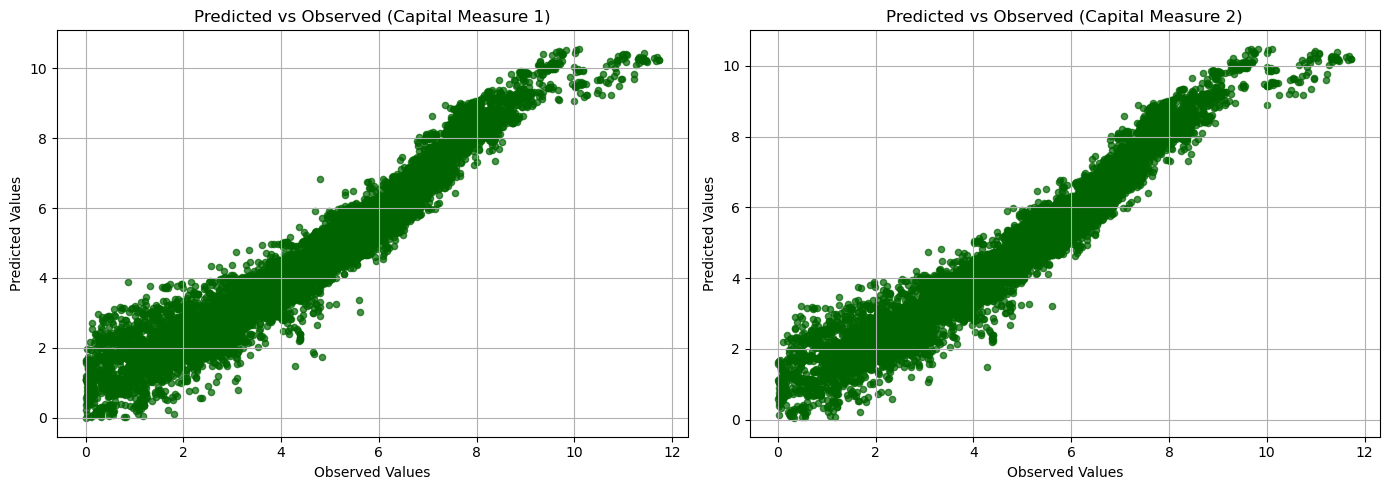

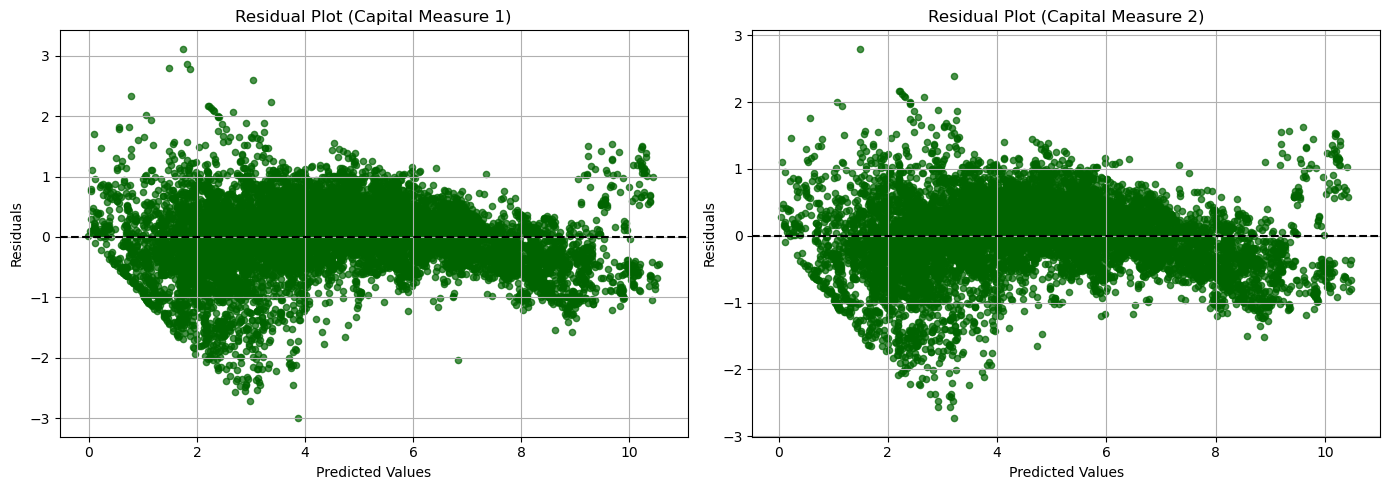

In [30]:
# Actual values
y_actual1 = capital1['Revenue - Total']
y_actual2 = capital2['Revenue - Total']

# Predicted values from each model
pred1 = ols1.predict(variables_to_include_ols1)
pred2 = ols2.predict(variables_to_include_ols2)

# Pair actual and predicted values with model labels
actuals_preds = [(capital1['Revenue - Total'], pred1, 'Capital Measure 1'),
                 (capital2['Revenue - Total'], pred2, 'Capital Measure 2')]

# --- Predicted vs Observed ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, (y_actual, y_pred, label) in zip(axes, actuals_preds):
    ax.scatter(y_actual, y_pred, alpha=0.7, s=20, color='darkgreen')
    ax.set_title(f"Predicted vs Observed ({label})")
    ax.set_xlabel("Observed Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- Residual Plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, (y_actual, y_pred, label) in zip(axes, actuals_preds):
    residuals = y_actual - y_pred
    ax.scatter(y_pred, residuals, alpha=0.7, s=20, color='darkgreen')
    ax.axhline(y=0, color='black', linestyle='--')
    ax.set_title(f"Residual Plot ({label})")
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.grid(True)

plt.tight_layout()
plt.show()

#### **Testing for Heteroscedasticity**

In [31]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols

In [32]:
white_test = het_white(ols2.resid,  ols2.model.exog)
bp_test = het_breuschpagan(ols2.resid, ols2.model.exog)


In [33]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_test = dict(zip(labels, bp_test))
white_test = dict(zip(labels, white_test))

test = pd.DataFrame(bp_test, white_test)

test = test.iloc[0:2, :].transpose()

test.rename(columns={'LM Statistic': 'White Test', 'LM-Test p-value': 'BP Test'})

,White Test,BP Test
LM Statistic,3.400016e+02,3.400016e+02
LM-Test p-value,1.477737e-74,1.477737e-74
F-Statistic,1.753903e+02,1.753903e+02
F-Test p-value,1.051386e-75,1.051386e-75


LM-Test p-value at 0.036 indicates that there is heteroscedasticity.

#### **Identifying Heterogeneity**

In [34]:
data = financial_data.dropna()

In [35]:
unit = 'Ticker Symbol'
outcome = 'Revenue - Total'

# Group by unit and compute group means
group_means = data.groupby(unit)[outcome].mean()
overall_mean = data[outcome].mean()

# Between-group variation: how much group means deviate from overall mean
between_var = ((group_means - overall_mean) ** 2 * data.groupby(unit).size()).sum()

# Within-group variation: variation inside each group
within_var = data.groupby(unit).apply(
    lambda group: ((group[outcome] - group[outcome].mean()) ** 2).sum()).sum()

# Total variation
total_var = ((data[outcome] - overall_mean) ** 2).sum()

# Proportions
print(f"Between-unit variation: {between_var / total_var:.2%}")
print(f"Within-unit variation: {within_var / total_var:.2%}")

Between-unit variation: 88.86%
Within-unit variation: 11.14%


/var/folders/lj/83l4br5s2cz7n6sftfx0dy9c0000gn/T/ipykernel_69603/4100035931.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  within_var = data.groupby(unit).apply(


Significant between-unit variation, indicating heterogeneity across units.

### **Fixed Effects Models**

In [38]:
from linearmodels.panel import PanelOLS

# Step 1: Drop missing
data = capital1.dropna(subset=['Ticker Symbol', 'time', 'Revenue - Total', 'Capital Measure 1', 'Total Employment'])

# Step 2: Set firm and time index
data = data.set_index(['Ticker Symbol', 'time'])
data['firm_id'] = data.index.get_level_values('Ticker Symbol')
data['time_id'] = data.index.get_level_values('time')

# Step 3: Reset index temporarily
data_reset = data.reset_index()

# Step 4: Create time dummies
time_dummies = pd.get_dummies(data_reset['time'], prefix='quarter', drop_first=True)

# Step 5: Set up X and y
X = pd.concat([data_reset[['Capital Measure 1', 'Total Employment']], time_dummies], axis=1)
X = sm.add_constant(X)

y = data_reset['Revenue - Total']

# Step 6: Set back to MultiIndex
X.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])
y.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])

# Step 7: Set up cluster IDs
clusters = data_reset[['firm_id', 'time_id']]
clusters.index = X.index  # VERY IMPORTANT: align cluster index with X and y!

# Step 8: Run Fixed Effects model
FE1 = PanelOLS(y, X, entity_effects=True)
FE1_results = FE1.fit(cov_type='clustered', clusters=clusters)

# Step 9: View results
FE1_results.summary

/Users/alexanderperalta/anaconda3/envs/finance_project/lib/python3.11/site-packages/linearmodels/panel/results.py:88: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


Dep. Variable:,Revenue - Total,R-squared:,0.6827
Estimator:,PanelOLS,R-squared (Between):,0.8661
No. Observations:,12747,R-squared (Within):,0.6827
Date:,"Sun, Jan 25 2026",R-squared (Overall):,0.8922
Time:,12:27:41,Log-likelihood,-278.99
Cov. Estimator:,Clustered,,
,,F-statistic:,418.82
Entities:,618,P-value,0.0000
Avg Obs:,20.626,Distribution:,"F(62,12067)"
Min Obs:,1.0000,,
Max Obs:,58.000,F-statistic (robust):,28.433


In [39]:
# Step 1: Drop missing
data = capital2.dropna(subset=['Ticker Symbol', 'time', 'Revenue - Total', 'Capital Measure 2', 'Total Employment'])

# Step 2: Set firm and time index
data = data.set_index(['Ticker Symbol', 'time'])
data['firm_id'] = data.index.get_level_values('Ticker Symbol')
data['time_id'] = data.index.get_level_values('time')

# Step 3: Reset index temporarily
data_reset = data.reset_index()

# Step 4: Create time dummies
time_dummies = pd.get_dummies(data_reset['time'], prefix='quarter', drop_first=True)

# Step 5: Set up X and y
X = pd.concat([data_reset[['Capital Measure 2', 'Total Employment']], time_dummies], axis=1)
X = sm.add_constant(X)

y = data_reset['Revenue - Total']

# Step 6: Set back to MultiIndex
X.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])
y.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])

# Step 7: Set up cluster IDs
clusters = data_reset[['firm_id', 'time_id']]
clusters.index = X.index  # VERY IMPORTANT: align cluster index with X and y!

# Step 8: Run Fixed Effects model
FE2 = PanelOLS(y, X, entity_effects=True)
FE2_results = FE2.fit(cov_type='clustered', clusters=clusters)

# Step 9: View results
FE2_results.summary

/Users/alexanderperalta/anaconda3/envs/finance_project/lib/python3.11/site-packages/linearmodels/panel/results.py:88: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


Dep. Variable:,Revenue - Total,R-squared:,0.6579
Estimator:,PanelOLS,R-squared (Between):,0.8643
No. Observations:,10970,R-squared (Within):,0.6579
Date:,"Sun, Jan 25 2026",R-squared (Overall):,0.8807
Time:,12:27:49,Log-likelihood,301.15
Cov. Estimator:,Clustered,,
,,F-statistic:,338.00
Entities:,542,P-value,0.0000
Avg Obs:,20.240,Distribution:,"F(59,10369)"
Min Obs:,1.0000,,
Max Obs:,55.000,F-statistic (robust):,77.966


### **Implementing Olley-Pakes**

Olley-Pakes use the following production function:

$$ y_{it} = \beta_0 + \beta_a a_{it} + \beta_k k_{it} + \beta_l l_{it} + \omega_{it} + \nu_{it} $$

where $y_{it}$ is the log of output (value added) from plant i at time t, $a_{it}$ its age, $k_{it}$ the log of its capital input, $l_{it}$ the log of its labor input, $\omega_{it}$ its productivity, and $\nu_{it}$ is either measurement error (which can be serially correlated) or a shock to productivity which is not forecastable during the period in which labor can be adjusted. Here both $\omega$ and $\nu$ are unobserved. The distinction is that $\omega$ is a state variable in the firm's decision problem, and hence a determinant of both liquidation and input demand decisions, while $\nu$ is not.

In [54]:
df_OP = capital2[['Ticker Symbol', 
                  'time',
                  'Total Employment',
                  'Capital Measure 1',
                  'Capital Measure 2',
                  'Capital Expenditure',
                  'Revenue - Total',
                  'Cost of Goods Sold']]

capital_measure = 'Capital Measure 2'

In [55]:
df_OP = df_OP.dropna(subset=['Capital Expenditure', capital_measure, 'Revenue - Total']).reset_index(drop=True)

In [56]:
df_OP['Survival'] = 1

symbols = list(df_OP['Ticker Symbol'].unique())

dfs = {}
for symbol in symbols:
    dfs[symbol] = df_OP[df_OP['Ticker Symbol'] == symbol].copy()

for symbol, df in dfs.items():
    try:

        if df['time'].iloc[-1] != 64.0:
            df.loc[df.index[-1], 'Survival'] = 0

        df['y_next'] = df['Revenue - Total'].shift(-1)
        df['l_next'] = df['Total Employment'].shift(-1)
        df['k_next'] = df[capital_measure].shift(-1)        

        dfs[symbol] = df

    except KeyError:
        print(f"Missing required columns in {symbol}, skipping.")

df_OP = pd.DataFrame()

for df in dfs.values():
    df_OP = pd.concat([df_OP, df])


The "partially linear" model below: $$y_{it} = \beta_l l_{it} + \Phi_t(i_{it}, a_{it}, k_{it})+\Nu_{it}$$

is a semiparametric regression model (Engel, Granger, Rice, and Weiss (1986) and Robinson (1988)) which identifies $\beta_l$ but not the production function coefficients of capital and age, $\beta_a$ and $\beta_k$. That is, the equation does not allow us to separate the effect of capital and age on the investment decision from their effect on output. 

We estimate the partially linear model as follows:

In [57]:
from sklearn.preprocessing import PolynomialFeatures

y = 'Revenue - Total'
i = 'Capital Expenditure'
k = capital_measure
l = 'Total Employment'

cols_to_check = [y, i, k, l]
df_OP = df_OP.replace([np.inf, -np.inf], np.nan).dropna(subset=cols_to_check)

# Create polynomial features of i, k
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(df_OP[[i, k]])

# Names for the polynomial terms
poly_features = poly.get_feature_names_out([i, k])

# Put it into a DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly_features, index=df_OP.index)

# Add labor input separately (because it's linear)
X_poly_df[l] = df_OP[l]

# Now regress y on labor + the flexible phi(i,a,k)
X = sm.add_constant(X_poly_df)
y = df_OP[y]

OP_Stage1 = sm.OLS(y, X).fit()

print(OP_Stage1.summary())

                            OLS Regression Results                            
Dep. Variable:        Revenue - Total   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 1.313e+04
Date:                Sun, 25 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:29:55   Log-Likelihood:                -3855.1
No. Observations:                6360   AIC:                             7732.
Df Residuals:                    6349   BIC:                             7806.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

To identify $\beta_a$ and $\beta_k$ we use, in addition to the estimates of $\beta_l$ and $\Phi_t(\cdot)$ obtained from the partially linear model, estimates of the survival probabilities. These probabilities are given by: 

$$
\begin{aligned}
\quad \text{Pr} \{ \chi_{t+1} = 1 &| \underline{\omega}_{t+1}(k_{t+1}, a_{t+1}), J_t \} \\
&= \text{Pr} \{ \omega_{t+1} \geq \underline{\omega}_{t+1}(k_{t+1}, a_{t+1}) | \underline{\omega}_{t+1}(k_{t+1}, a_{t+1}), \omega_t \} \\
&= \wp_t \{ \underline{\omega}_{t+1}(k_{t+1}, a_{t+1}), \omega_t \} \\
&= \wp_t (i_t, a_t, k_t) \\
&\equiv P_t
\end{aligned}
$$

In [58]:
beta_l = OP_Stage1.params['Total Employment']
df_OP['phi_hat'] = OP_Stage1.predict(X)

X_probit = X_poly_df.drop(columns=['Total Employment']) 
X_probit = sm.add_constant(X_probit)

# 4. Estimate Probit (Survival on Poly(i, k))
OP_probit_model = sm.Probit(df_OP['Survival'], X_probit).fit() # Use X_probit here

# 6. Predict survival probabilities (Crucial Step!)
df_OP['survival_prob'] = OP_probit_model.predict(X_probit)

Optimization terminated successfully.
         Current function value: 0.273602
         Iterations 6


In [59]:
OP_probit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:               Survival   No. Observations:                 6360
Model:                         Probit   Df Residuals:                     6350
Method:                           MLE   Df Model:                            9
Date:                Sun, 25 Jan 2026   Pseudo R-squ.:                 0.01609
Time:                        12:29:56   Log-Likelihood:                -1740.1
converged:                       True   LL-Null:                       -1768.6
Covariance Type:            nonrobust   LLR p-value:                 5.218e-09
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.1668      0.284      4.104      0.000       0.610       1.724
Capital Expenditure                        -0.4305      0.195     -2.211      0.027      -0.812      -0.049
Capital Measure 2                           0.2826      0.232      1.220      0.223      -0.172       0.737
Capital Expenditure^2                       0.0612      0.059      1.036      0.300      -0.055       0.177
Capital Expenditure Capital Measure 2      -0.0174      0.121     -0.144      0.886      -0.255       0.220
Capital Measure 2^2                        -0.0089      0.073     -0.122      0.903      -0.152       0.134
Capital Expenditure^3                       0.0167      0.008      2.194      0.028       0.002       0.032
Capital Expenditure^2 Capital Measure 2    -0.0486      0.021     -2.309      0.021      -0.090      -0.007
Capital Expenditure Capital Measure 2^2     0.0387      0.022      1.799      0.072      -0.003       0.081
Capital Measure 2^3                        -0.0094      0.008     -1.164      0.244      -0.025       0.006
===========================================================================================================
"""

The third (and final) step of the estimation procedure takes the estimates of $\beta_l$, $\phi_t$, and $P_t$ from the first two steps, substitutes them into equation (12) for the true $\beta_l$, $\phi_t$, and $P_t$, and then obtains estimates of $(\beta_a, \beta_k)$, by minimizing the sum of squared residuals in that equation. Here we try both a series and a kernel estimator of the unknown $g(P_t, h_t)$ function. Recall that we estimate $\phi_t$ and $h_t = \phi_t - \beta_a a_t - \beta_k k_t$, so the values of the regressors that determine $g(\cdot)$ depend upon the values of the parameters of interest.

For the series estimator we used a fourth order polynomial expansion in $(P_t, h_t)$ (and again there was almost no difference in either the sum of squares, or in the coefficients of interest, between the third and the fourth order approximation). Thus the series estimator is obtained by running nonlinear least squares on the equation

$$
\quad y_{t+1} - b_l l_{t+1} = c + \beta_a a_{t+1} + \beta_k k_{t+1} + \sum_{j=0}^{4-m} \sum_{m=0}^{4} \beta_{mj} \hat{h}_t^m \hat{P}_t^j + e_t
$$

with 

$$
\hat{h}_t = \hat{\phi}_t - \beta_a a_t - \beta_k k_t.
$$

Here $\hat{\phi}_t$ and $b_l$ are taken from the estimates of the partially linear model in (8), and $\hat{P}_t$ is taken from the kernel estimates of the survival probability in (10).

The kernel estimator is obtained by forming a kernel estimator of the regression of 

$$
y_{t+1} - b_l l_{t+1} - \beta_a a_{t+1} - \beta_k k_{t+1}
$$

on $\hat{P}_t$ and $\hat{h}_t = \hat{\phi}_t - \beta_a a_t - \beta_k k_t$, for different values of $(\beta_a, \beta_k)$, and then using a nonlinear search routine to find that value of $(\beta_a, \beta_k)$ that minimized the sum of squared residuals from this regression. Again the results are the bias reducing kernels in Bierens (1987) (though we also used a standard normal kernel with little difference in the resulting coefficient estimates).$^{23}$

In [60]:
from scipy.optimize import minimize_scalar

# Drop missing rows for the second stage
df_2nd = df_OP.dropna(subset=['y_next', 'k_next', 'l_next', 
                              'phi_hat', 'survival_prob', capital_measure]).copy()

# Variables
Y_next = df_2nd['y_next']
L_next = df_2nd['l_next']
K_next = df_2nd['k_next']
K_curr = df_2nd[capital_measure]
Phi_hat = df_2nd['phi_hat']
P_hat = df_2nd['survival_prob']
beta_l_hat = beta_l # From Stage 1

# Define the Objective Function for NLLS
def nlls_objective(beta_k_guess):
    # 1. Construct the dependent variable: y_{t+1} - beta_l * l_{t+1}
    lhs = Y_next - (beta_l_hat * L_next)
    
    # 2. Construct the term inside g(): h_t = phi_t - beta_k * k_t
    h_hat = Phi_hat - (beta_k_guess * K_curr)
    
    # 3. Create Polynomial features for g(P_t, h_t)
    # We use a 3rd degree polynomial approximation for the unknown function g()
    # Stack P_hat and h_hat to create interaction terms
    X_g = np.column_stack((P_hat, h_hat))
    poly = PolynomialFeatures(degree=3, include_bias=True)
    X_poly = poly.fit_transform(X_g)
    
    # 4. The regression equation is: (LHS - beta_k * K_{t+1}) = g(P, h) + error
    # We treat (LHS - beta_k * K_{t+1}) as the target for the polynomial to fit
    target_for_g = lhs - (beta_k_guess * K_next)
    
    # 5. Estimate the polynomial coefficients (gammas) via OLS
    # (We don't need the coeffs, just the residuals)
    model = sm.OLS(target_for_g, X_poly).fit()
    
    # 6. Return Sum of Squared Residuals
    return model.ssr

# Optimize to find beta_k
# We assume beta_k is likely between 0 and 1 for stability
result = minimize_scalar(nlls_objective, bounds=(0.0, 1.0), method='bounded')

beta_k_final = result.x
print(f"Estimated Beta_K: {beta_k_final}")

# Update dataframe with final TFP using the consistent parameters
df_OP['TFP_OP'] = np.exp(df_OP['Revenue - Total'] - 
                        (beta_l_hat * df_OP['Total Employment']) - 
                        (beta_k_final * df_OP[capital_measure]))

Estimated Beta_K: 0.41915014497813635


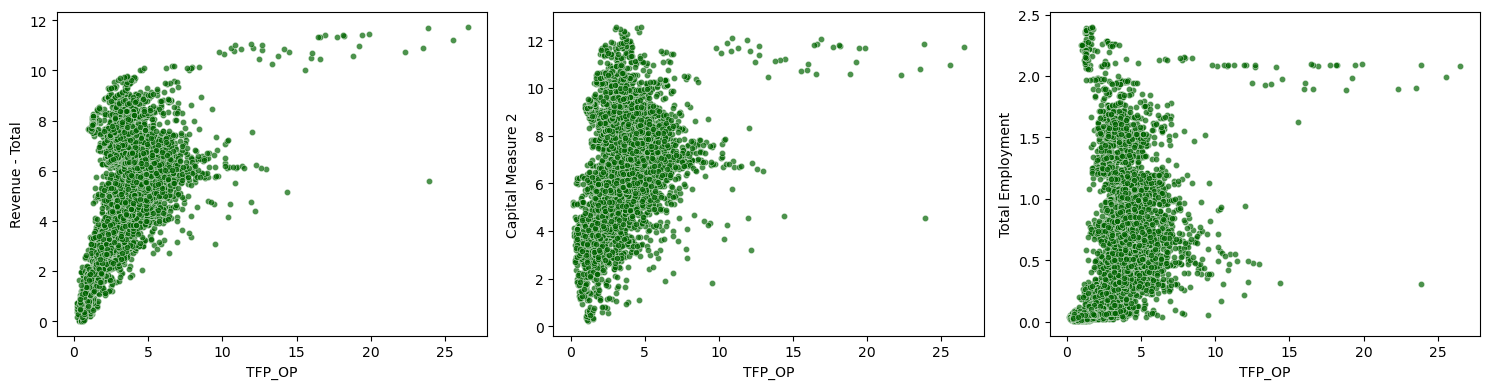

In [61]:
import seaborn as sns

pair_plot_df = df_OP[['Revenue - Total',
                      'Capital Measure 2',
                      'Total Employment',
                      'TFP_OP']]

pair_plot_df = pair_plot_df.reset_index()
pair_plot_df.drop(columns={'index'}, inplace=True)

main_var = 'TFP_OP'
other_vars = [col for col in pair_plot_df.columns if col != main_var]

fig, axes = plt.subplots(1, len(other_vars), figsize=(5 * len(other_vars), 4))
if len(other_vars) == 1:
    axes = [axes]  # make iterable

for ax, var in zip(axes, other_vars):
    
    sns.scatterplot(x=pair_plot_df[main_var], y=pair_plot_df[var], alpha=0.7, s=20, color='darkgreen', ax=ax)
    ax.set_xlabel(main_var)
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

In [62]:
df_OP.dropna(subset='time', inplace=True)

In [63]:
# Invert the quarter_map dictionary
inv_quarter_map = {v: k for k, v in quarter_map.items()}

# Map the 'time' column to actual quarter-year labels
df_OP['quarter_label'] = df_OP['time'].map(inv_quarter_map)

# Split into year and quarter
df_OP['quarter'] = df_OP['quarter_label'].str[-1].astype(int)
df_OP['year'] = df_OP['quarter_label'].str[:4].astype(int)

      unweighted_mean_p  weighted_mean_p  covariance_term
year                                                     
2011           1.146974         1.273208         0.126234
2012           1.147275         1.306888         0.159613
2013           1.121103         1.265967         0.144863
2014           1.120600         1.263531         0.142931
2015           1.079345         1.239689         0.160343


/var/folders/lj/83l4br5s2cz7n6sftfx0dy9c0000gn/T/ipykernel_69603/2879262289.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_p = OP_decomp.groupby('year').apply(


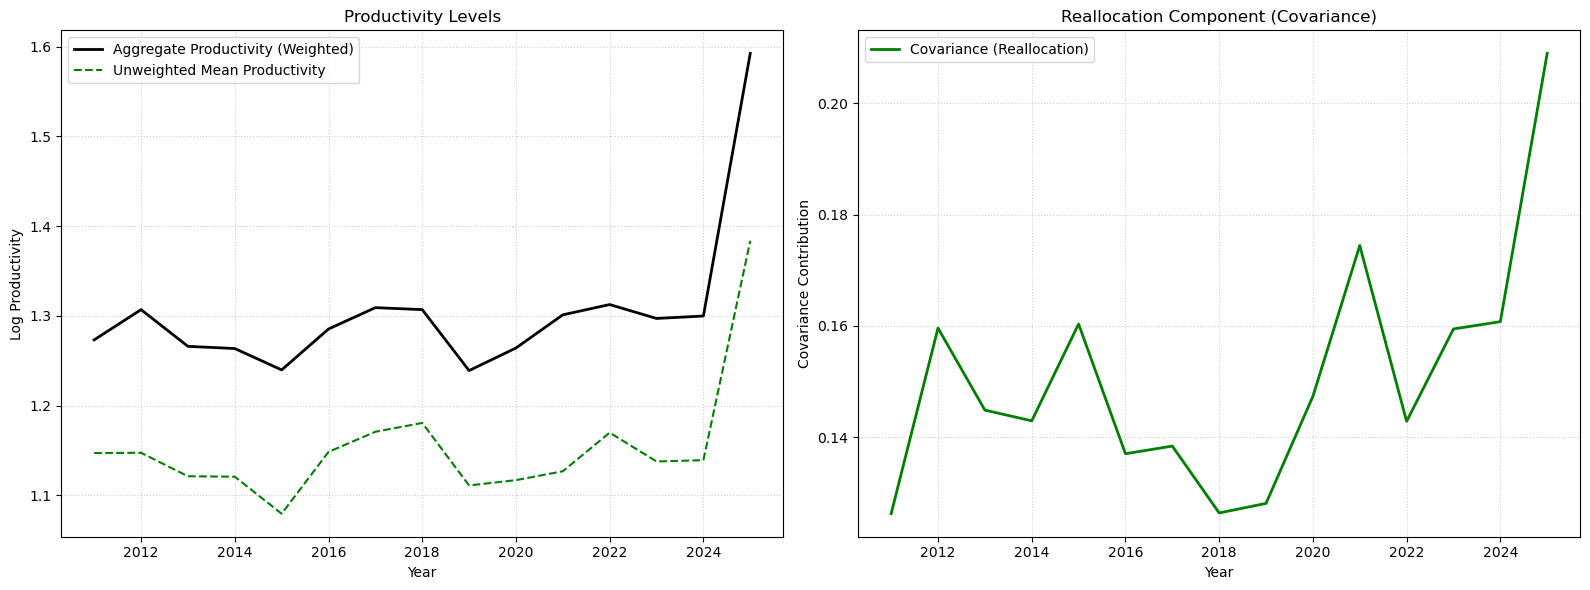

In [64]:
# Prepare data for decomposition
OP_decomp = df_OP.dropna(subset=['TFP_OP', 'Revenue - Total', 'year']).copy()

# 1. Calculate log productivity (little p) and shares (s)
# Note: Olley-Pakes usually decompose the log productivity, but can be done on levels.
# We will use log productivity as per Eq 16 in the paper.
OP_decomp['p_it'] = np.log(OP_decomp['TFP_OP'])

# Calculate Industry Share s_it
OP_decomp['year_total_rev'] = OP_decomp.groupby('year')['Revenue - Total'].transform('sum')
OP_decomp['s_it'] = OP_decomp['Revenue - Total'] / OP_decomp['year_total_rev']

# 2. Calculate Unweighted Mean Productivity (p_bar_t)
p_bar_t = OP_decomp.groupby('year')['p_it'].mean().rename('unweighted_mean_p')

# 3. Calculate the Cross-Sectional Covariance term
# Cov(s, p) = Sum((s_it - s_bar_t) * (p_it - p_bar_t))
# This is equivalent to weighted_avg - unweighted_avg
weighted_avg_p = OP_decomp.groupby('year').apply(
    lambda x: np.sum(x['s_it'] * x['p_it'])
).rename('weighted_mean_p')

# Combine into a results table
decomposition_df = pd.concat([p_bar_t, weighted_avg_p], axis=1)
decomposition_df['covariance_term'] = decomposition_df['weighted_mean_p'] - decomposition_df['unweighted_mean_p']

print(decomposition_df.head())

# 4. Plotting Side-by-Side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: Weighted vs. Unweighted Productivity
ax1.plot(decomposition_df.index, decomposition_df['weighted_mean_p'], 
         label='Aggregate Productivity (Weighted)', linewidth=2, color='black')
ax1.plot(decomposition_df.index, decomposition_df['unweighted_mean_p'], 
         label='Unweighted Mean Productivity', linestyle='--', color='green')

ax1.set_title('Productivity Levels')
ax1.set_xlabel('Year')
ax1.set_ylabel('Log Productivity')
ax1.legend(loc='best')
ax1.grid(True, linestyle=':', alpha=0.6)

# Right Plot: Covariance (Reallocation) Only
ax2.plot(decomposition_df.index, decomposition_df['covariance_term'], 
         label='Covariance (Reallocation)', color='green', linewidth=2)

ax2.set_title('Reallocation Component (Covariance)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Covariance Contribution')
ax2.legend(loc='best')
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

In [65]:
from scipy.optimize import minimize

# 1. Prepare Data for Robustness Test
# We need rows that have all variables, including current labor (l_t)
df_robust = df_OP.dropna(subset=['y_next', 'k_next', 'l_next', 
                                 'phi_hat', 'survival_prob', 
                                 capital_measure, 'Total Employment']).copy()

# Variables mapping
Y_next = df_robust['y_next']
L_next = df_robust['l_next']        # Labor at t+1
K_next = df_robust['k_next']        # Capital at t+1
K_curr = df_robust[capital_measure] # Capital at t
L_curr = df_robust['Total Employment'] # Labor at t (The variable for the test)
Phi_hat = df_robust['phi_hat']
P_hat = df_robust['survival_prob']
beta_l_fixed = beta_l # Fixed from Stage 1

# 2. Define NLLS Objective with Extra Parameter (Gamma_L)
def robustness_objective(params):
    # Unpack parameters: we are estimating beta_k AND gamma_l simultaneously
    b_k, gam_l = params
    
    # Dependent Variable: y_{t+1} - beta_l * l_{t+1}
    lhs = Y_next - (beta_l_fixed * L_next)
    
    # Construct the Index for g(): h_t = phi_t - beta_k * k_t
    h_hat = Phi_hat - (b_k * K_curr)
    
    # Create Polynomial features for g(P_t, h_t)
    X_g = np.column_stack((P_hat, h_hat))
    poly = PolynomialFeatures(degree=3, include_bias=True)
    X_poly = poly.fit_transform(X_g)
    
    # The regression equation becomes:
    # LHS = beta_k * k_{t+1} + gamma_l * l_t + g(P, h)
    # Rearrange to isolate g(): Target_for_g = LHS - b_k * K_next - gam_l * L_curr
    target_for_g = lhs - (b_k * K_next) - (gam_l * L_curr)
    
    # Estimate polynomial coeffs via OLS to fit g()
    model = sm.OLS(target_for_g, X_poly).fit()
    
    # Return Sum of Squared Residuals
    return model.ssr

# 3. Optimize
# Initial guess: beta_k = previous estimate, gamma_l = 0
initial_guess = [beta_k_final, 0.0]

# Run minimization
res_robust = minimize(robustness_objective, initial_guess, method='L-BFGS-B', 
                      bounds=[(0, 1), (-1, 1)])

beta_k_robust, gamma_l_robust = res_robust.x

# 4. Interpret Results
print("--- Robustness Test Results (Section 4.1) ---")
print(f"Original Beta_K: {beta_k_final:.4f}")
print(f"Robust Beta_K:   {beta_k_robust:.4f}")
print(f"Gamma_L (Coeff on Lagged Labor): {gamma_l_robust:.4f}")

if abs(gamma_l_robust) < 0.05: # Threshold depends on standard errors, typically heuristic here
    print("PASS: Gamma_L is close to zero. The invertibility assumption holds.")
else:
    print("FAIL: Gamma_L is large. Labor might be determining investment decisions.")

--- Robustness Test Results (Section 4.1) ---
Original Beta_K: 0.4192
Robust Beta_K:   0.4040
Gamma_L (Coeff on Lagged Labor): 1.0000
FAIL: Gamma_L is large. Labor might be determining investment decisions.


### **Implementing D. A. ACKERBERG, K. CAVES, AND G. FRAZER**

We estimate the following Leontief-derived value-added production function:

$$Y_{it} = \beta_0 K^{\beta_{k}}_{it} L^{\beta_{l}}_{it} e^{\omega_{it}} e^{\epsilon_{it}}$$

When we use the ACF procedure, we use M_{it} to invert the productivity shock.

In [102]:
ACF_model = financial_data[['Ticker Symbol',
                            'time',
                            'Total Employment',
                            'Capital Measure 1',
                            'Capital Measure 2', 
                            'Revenue - Total',
                            'Inventory - Raw Materials',
                            'Cost of Goods Sold']]

In [103]:
ACF_model = ACF_model.dropna().reset_index(drop=True)


In [104]:
k = 'Capital Measure 2'
m = 'Cost of Goods Sold'
l = 'Total Employment'
y = 'Revenue - Total'
t = 'time'

For our procedure, our first stage is simply OLS of yit on $k_{it}$, $l_{lt}$, and $m_{it}$. More generally, one would want higher order polynomials in the explanatory variables, but because, in our setup, optimal $m_{it}$ is actually a linear function of $k_{it}$ > $l_{it}$, and $\omega_{it}$ we simply used a first order polynomial.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# 1. Include 'l' (labor) in the list of variables
# 2. Increase degree to 2 or 3 for flexible approximation (unless the DGP is linear)
poly = PolynomialFeatures(degree=3, include_bias=False)

# Pass k, l, m, and t into the polynomial generator
X_poly = poly.fit_transform(ACF_model[[k, l, m, t]]) 
poly_features = poly.get_feature_names_out([k, l, m, t])

# Create DataFrame from polynomial terms
X_poly_df = pd.DataFrame(X_poly, columns=poly_features, index=ACF_model.index)

# Create model inputs
X = sm.add_constant(X_poly_df)
y_vec = ACF_model[y].reset_index(drop=True)

# Fit OLS model (The First Stage)
# Recovers Phi_hat, which contains the 'predictable' part of output
ACF_stage1 = sm.OLS(y_vec, X).fit()
print(ACF_stage1.summary())

                            OLS Regression Results                            
Dep. Variable:        Revenue - Total   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.238e+04
Date:                Sun, 25 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:08:28   Log-Likelihood:                -86139.
No. Observations:               11558   AIC:                         1.723e+05
Df Residuals:                   11529   BIC:                         1.725e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In the second stage, our estimation is based on the following moments (where $\tilde{\beta}_0$ = ln($\beta_0$)):

\begin{equation}
E \left[
\begin{aligned}
    & \left( y_{it} - \widetilde{\beta}_0 - \beta_k k_{it} - \beta_l l_{it} \right. \\
    & \quad \left. - \rho \cdot \left( \widetilde{\Phi}_{t-1}(k_{it-1}, l_{it-1}, m_{it-1}) - \widetilde{\beta}_0 - \beta_k k_{it-1} - \beta_l l_{it-1} \right) \right) \\
    & \otimes \begin{pmatrix}
        1 \\
        k_{it} \\
        l_{it-1} \\
        \widetilde{\Phi}_{t-1}(k_{it-1}, l_{it-1}, m_{it-1})
    \end{pmatrix}
\end{aligned}
\right] = 0.
\tag{40}
\end{equation}

In [106]:
# Store fitted values for Stage 2
ACF_model['phi_hat'] = ACF_stage1.fittedvalues

In [109]:
from scipy.optimize import minimize

# Create the Lagged Labor Instrument
ACF_model['l_lag'] = ACF_model.groupby('Ticker Symbol')[l].shift(1)

# Drop missing values caused by the lag
df_stage2 = ACF_model.dropna(subset=['l_lag', 'phi_hat', k, l]).copy()


# --- THE OBJECTIVE FUNCTION ---
def acf_gmm_objective(params, df):
    """
    Calculates the GMM objective value for a guess of beta_k and beta_l.
    Implements the "concentrated" approach from Section A.4.
    """
    beta_k, beta_l = params
    
    # 1. Calculate Implied Productivity (+ Constant) 
    # We use the phi_hat estimated in Stage 1
    # Omega_tilde = Phi_hat - bk*k - bl*l
    df['omega_tilde'] = df['phi_hat'] - (beta_k * df[k]) - (beta_l * df[l])
    
    # Create the lag of this implied productivity for the AR(1) process
    # We must group by firm again to ensure we don't lag across different firms
    df['omega_tilde_lag'] = df.groupby('Ticker Symbol')['omega_tilde'].shift(1)
    
    # We need a temporary clean dataframe for the AR(1) regression inside the loop
    # (removing the new NAs created by the omega lag)
    reg_df = df.dropna(subset=['omega_tilde', 'omega_tilde_lag'])
    
    # 2. "Concentrate Out" Rho 
    # Regress Omega_tilde on Lagged_Omega_tilde to find rho and residuals (xi)
    # The intercept here captures beta_0 * (1-rho)
    X_ar1 = sm.add_constant(reg_df['omega_tilde_lag'])
    ar1_model = sm.OLS(reg_df['omega_tilde'], X_ar1).fit()
    
    # The residuals are the "innovations" (xi_it) 
    residuals_xi = ar1_model.resid
    
    # 3. Form Moment Conditions 
    # The paper explicitly minimizes E[xi * instruments] = 0.
    # Instruments: Current Capital (k) and Lagged Labor (l_lag)
    
    instr_k = reg_df[k]
    instr_l_lag = reg_df['l_lag']
    
    # Calculate sample moments (mean of xi * instrument)
    moment_k = np.mean(residuals_xi * instr_k)
    moment_l = np.mean(residuals_xi * instr_l_lag)
    
    # GMM Objective: Sum of squared moments
    # (You can weight these if using Identity matrix, simple sum is fine for exactly identified)
    return moment_k**2 + moment_l**2

# --- OPTIMIZATION ---

# Initial guess for [beta_k, beta_l]
# Standard Cobb-Douglas guesses are often around 0.3 or 0.4 for k, 0.6 for l
initial_guess = [0.3, 0.6]

result = minimize(acf_gmm_objective, 
                  initial_guess, 
                  args=(df_stage2,), 
                  method='Nelder-Mead', # Robust method for non-smooth surfaces
                  options={'disp': True})

beta_k_est, beta_l_est = result.x

print("-" * 30)
print(f"Estimated Beta_k: {beta_k_est:.4f}")
print(f"Estimated Beta_l: {beta_l_est:.4f}")
print("-" * 30)

Optimization terminated successfully.
         Current function value: 0.069122
         Iterations: 51
         Function evaluations: 94
------------------------------
Estimated Beta_k: 0.1255
Estimated Beta_l: 0.9350
------------------------------


In [112]:
ACF_model['ln_TFP'] = ACF_model['phi_hat'] - (beta_k_est * ACF_model[k]) - (beta_l_est * ACF_model[l])

ACF_model['ln_TFP'].describe()

count     11558.000000
mean        174.782995
std        2449.148304
min      -19096.619440
25%          -0.965334
50%          23.832766
75%          97.695838
max      110381.307514
Name: ln_TFP, dtype: float64

In [113]:
# Calculate final omega series using optimal betas
df_stage2['omega_final'] = df_stage2['phi_hat'] - (beta_k_est * df_stage2[k]) - (beta_l_est * df_stage2[l])
df_stage2['omega_final_lag'] = df_stage2.groupby('Ticker Symbol')['omega_final'].shift(1)

# Run the AR(1) regression one last time
final_reg_df = df_stage2.dropna(subset=['omega_final', 'omega_final_lag'])
X_final = sm.add_constant(final_reg_df['omega_final_lag'])
final_ar1 = sm.OLS(final_reg_df['omega_final'], X_final).fit()

rho_est = final_ar1.params['omega_final_lag']
print(f"Estimated Rho:    {rho_est:.4f}")

Estimated Rho:    0.9984


In [116]:
from sklearn.preprocessing import PolynomialFeatures

# Update these imports
from scipy.optimize import minimize

def run_acf_on_sample(sample_df):
    # --- STAGE 1: Recover Phi (Same as before) ---
    poly = PolynomialFeatures(degree=3, include_bias=False)
    X_poly = poly.fit_transform(sample_df[[k, l, m, t]])
    
    X = sm.add_constant(pd.DataFrame(X_poly, index=sample_df.index))
    y_vec = sample_df[y]
    stage1 = sm.OLS(y_vec, X).fit()
    sample_df['phi_hat'] = stage1.fittedvalues
    
    # --- STAGE 2: Optimization with BOUNDS ---
    sample_df = sample_df.sort_values(by=['Ticker Symbol', 'time'])
    sample_df['l_lag'] = sample_df.groupby('Ticker Symbol')[l].shift(1)
    
    df_clean = sample_df.dropna(subset=['l_lag', 'phi_hat', k, l]).copy()
    
    # Define Bounds: (min, max)
    # Capital: 0.01 to 1.1
    # Labor:   0.01 to 1.5 (Allowing slight returns to scale, but preventing 50.0)
    bnds = ((0.01, 1.1), (0.01, 1.5))
    
    # Use L-BFGS-B solver which supports bounds
    # We use the initial guess from your point estimate [0.12, 0.93] to help convergence
    res = minimize(acf_gmm_objective, 
                   [0.12, 0.93], 
                   args=(df_clean,), 
                   method='L-BFGS-B', 
                   bounds=bnds)
    
    return res.x

# --- RUN BOOTSTRAP ---
n_bootstraps = 50 
boot_results = []
ticker_list = ACF_model['Ticker Symbol'].unique()

print(f"Starting {n_bootstraps} bootstrap iterations...")

for i in range(n_bootstraps):
    # 1. Resample FIRMS (Cluster Bootstrap), not rows
    resampled_tickers = np.random.choice(ticker_list, size=len(ticker_list), replace=True)
    
    # Reconstruct dataframe from selected tickers
    # (This ensures time-series structure is preserved for lags)
    boot_df = pd.concat([ACF_model[ACF_model['Ticker Symbol'] == tick] for tick in resampled_tickers])
    
    try:
        params = run_acf_on_sample(boot_df)
        boot_results.append(params)
        print(f"Iter {i+1}: k={params[0]:.3f}, l={params[1]:.3f}")
    except:
        print(f"Iter {i+1} failed")

# --- CALCULATE SE ---
# Convert results to DataFrame
boot_results_df = pd.DataFrame(boot_results, columns=['beta_k', 'beta_l'])

k_iqr = boot_results_df['beta_k'].quantile(0.75) - boot_results_df['beta_k'].quantile(0.25)
l_iqr = boot_results_df['beta_l'].quantile(0.75) - boot_results_df['beta_l'].quantile(0.25)

print(f"Robust SE Beta_k: {k_iqr / 1.349:.4f}")
print(f"Robust SE Beta_l: {l_iqr / 1.349:.4f}")

Starting 50 bootstrap iterations...
Iter 1: k=0.089, l=0.669
Iter 2: k=0.086, l=0.647
Iter 3: k=0.138, l=0.940
Iter 4: k=0.204, l=0.851
Iter 5: k=0.095, l=0.719
Iter 6: k=0.078, l=0.010
Iter 7: k=0.139, l=0.912
Iter 8: k=0.188, l=0.866
Iter 9: k=0.146, l=0.906
Iter 10: k=0.121, l=0.931
Iter 11: k=0.060, l=0.010
Iter 12: k=0.117, l=0.907
Iter 13: k=0.193, l=0.862
Iter 14: k=0.173, l=0.961
Iter 15: k=0.089, l=0.667
Iter 16: k=0.169, l=0.884
Iter 17: k=0.148, l=0.904
Iter 18: k=0.206, l=0.980
Iter 19: k=0.151, l=0.901
Iter 20: k=0.138, l=0.914
Iter 21: k=0.099, l=0.751
Iter 22: k=0.133, l=0.937
Iter 23: k=0.157, l=0.951
Iter 24: k=0.094, l=0.011
Iter 25: k=0.190, l=0.970
Iter 26: k=0.230, l=0.827
Iter 27: k=0.163, l=0.955
Iter 28: k=0.207, l=0.981
Iter 29: k=0.077, l=0.010
Iter 30: k=0.146, l=0.949
Iter 31: k=0.170, l=0.883
Iter 32: k=0.096, l=0.733
Iter 33: k=0.088, l=0.661
Iter 34: k=0.137, l=0.940
Iter 35: k=0.088, l=0.664
Iter 36: k=0.083, l=0.010
Iter 37: k=0.149, l=0.952
Iter 38: k=